In [1]:
from fastai.vision.all import *

In [2]:
MODELS_PATH = Path("./models")

In [3]:
EXAMPLES_PATH = Path('./examples')

In [4]:
MODELS_PATH.ls()

(#2) [Path('models/.ipynb_checkpoints'),Path('models/food-101-resnet50.pkl')]

In [5]:
EXAMPLES_PATH.ls()

(#19) [Path('examples/pad_thai.jpeg'),Path('examples/pizza.jpeg'),Path('examples/takoyaki.jpeg'),Path('examples/momo.jpeg'),Path('examples/falafel.jpeg'),Path('examples/paella.jpeg'),Path('examples/panna_cotta.jpeg'),Path('examples/ravioli.jpeg'),Path('examples/seaweed_sallad.jpeg'),Path('examples/shrimp_and_grits.jpeg')...]

In [6]:
def label_func(filepath):
    return filepath.parent.name

In [7]:
learn = load_learner(MODELS_PATH/'food-101-resnet50.pkl')

In [8]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [9]:
labels = learn.dls.vocab
# labels

In [10]:
def predict(img):
    img = PILImage.create(img)
    _pred, _pred_w_idx, probs = learn.predict(img)
    labels_probs = {labels[i]: float(probs[i]) for i, _ in enumerate(labels)}
    return labels_probs

In [11]:
examples = [f'{EXAMPLES_PATH}/{f.name}' for f in EXAMPLES_PATH.iterdir()]

In [12]:
# predict(examples[0])

In [13]:
from random import choice

example = choice(examples)

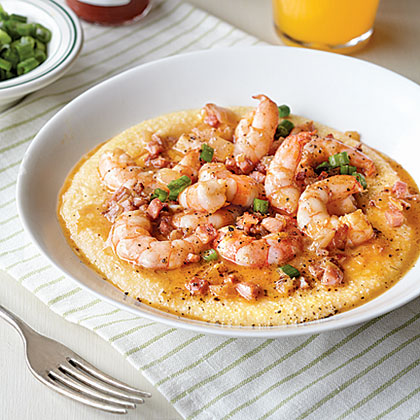

In [14]:
img = PILImage.create(example)
img

In [15]:
x, = first(learn.dls.test_dl([img]))

In [16]:
with torch.no_grad():
    output = learn.model.eval()(x)

In [17]:
cls = int(output.argmax())

In [18]:
learn.dls.vocab[cls]

'shrimp_and_grits'

In [19]:
x_dec = TensorImage(learn.dls.train.decode((x,))[0][0])

In [20]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [21]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [22]:
with HookBwd(learn.model[0][-1]) as hookg:
    with Hook(learn.model[0][-1]) as hook:
        output = learn.model.eval()(x)
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

/conda/envs/py310-cuda116/lib/python3.10/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [23]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

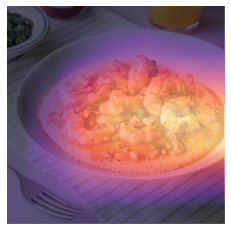

In [24]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.7, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [25]:
with HookBwd(learn.model[0][-2]) as hookg:
    with Hook(learn.model[0][-2]) as hook:
        output = learn.model.eval()(x)
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [26]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

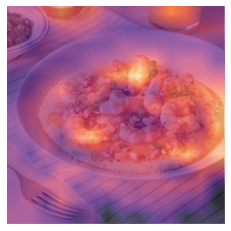

In [27]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.7, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [28]:
with HookBwd(learn.model[0][-3]) as hookg:
    with Hook(learn.model[0][-3]) as hook:
        output = learn.model.eval()(x)
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [29]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

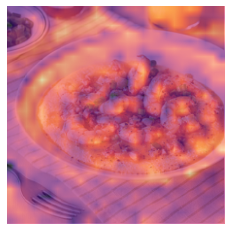

In [30]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.7, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [31]:
with HookBwd(learn.model[0][-4]) as hookg:
    with Hook(learn.model[0][-4]) as hook:
        output = learn.model.eval()(x)
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [32]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

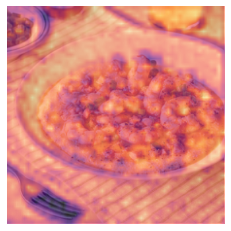

In [33]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.7, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [34]:
with HookBwd(learn.model[0][-5]) as hookg:
    with Hook(learn.model[0][-5]) as hook:
        output = learn.model.eval()(x)
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [35]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

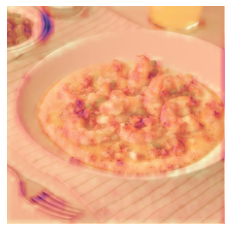

In [36]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.7, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [37]:
#learn.model